# Tutorial B2

This tutorial will introduce you to measuring the power consumption of a device under attack. It will demonstrate how you can view the difference in power consumption between assembly instructions.

If you haven't yet, you should probably complete Tutorial B1, which introduces bulding firmware, programming the target, and scripting.

## Setting up Firmware

In this tutorial, we will once again be working off of the simpleserial-base firmware.

Let's start by creating a new project and building our firmware:

In [1]:
%%bash
cd ../../hardware/victims/firmware/
mkdir -p simpleserial-base-lab2 && cp -r simpleserial-base/* $_
cd simpleserial-base-lab2

In [10]:
PLATFORM = "CWLITEARM"
CRYPTO_TARGET = "NONE"

In [11]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET"
cd ../../hardware/victims/firmware/simpleserial-base-lab2
make PLATFORM=$1 CRYPTO_TARGET=$2

rm -f -- simpleserial-base-CWLITEARM.hex
rm -f -- simpleserial-base-CWLITEARM.eep
rm -f -- simpleserial-base-CWLITEARM.cof
rm -f -- simpleserial-base-CWLITEARM.elf
rm -f -- simpleserial-base-CWLITEARM.map
rm -f -- simpleserial-base-CWLITEARM.sym
rm -f -- simpleserial-base-CWLITEARM.lss
rm -f -- objdir/*.o
rm -f -- objdir/*.lst
rm -f -- simpleserial-base.s simpleserial.s stm32f3_hal.s stm32f3_hal_lowlevel.s stm32f3_sysmem.s
rm -f -- simpleserial-base.d simpleserial.d stm32f3_hal.d stm32f3_hal_lowlevel.d stm32f3_sysmem.d
rm -f -- simpleserial-base.i simpleserial.i stm32f3_hal.i stm32f3_hal_lowlevel.i stm32f3_sysmem.i
.
-------- begin --------
arm-none-eabi-gcc (15:5.4.1+svn241155-1) 5.4.1 20160919
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

.
Compiling C: simpleserial-base.c
arm-none-eabi-gcc -c -mcpu=cortex-m4 -I. -mthumb -mfloat-a

As in the previous tutorial, we'll need to modify our firmware. Navigate to the `get_pt()` function:
```C
uint8_t get_pt(uint8_t* pt)
{
	/**********************************
	* Start user-specific code here. */
	trigger_high();
	
	//16 hex bytes held in 'pt' were sent
	//from the computer. Store your response
	//back into 'pt', which will send 16 bytes
	//back to computer. Can ignore of course if
	//not needed
	
	trigger_low();
	/* End user-specific code here. *
	********************************/
	simpleserial_put('r', 16, pt);
	return 0x00;
}

```

The easiest way to match power to different instructions will be to write some assembly ourselves. We can do this pretty easily inside the C code by using `asm volatile();`. To make the difference between instructions more obvious, we're going to look for a simple instruction that we'd expect to have low power consumption, as well as a more complex one.

### XMEGA/Avr Assembly

Atmel (who made the XMEGA/Avr microcontrollers before being bought by Microchip) typically includes all the info we'll need in the datasheet for their microcontroller, so you'll want to bring that up. If you're using the CWLite w/ XMEGA or XMEGA target board, [here's a link to its datasheet](http://ww1.microchip.com/downloads/en/DeviceDoc/atmel-8385-8-and-16-bit-avr-microcontroller-atxmega64a1u-atxmega128a1u_datasheet.pdf).

Some good canditates are `nop` for the simple instruction and `mul` for the complex one. Here's some background on these instructions:

**mul**
* Multiplies two 8-bit numbers together
* Takes 2 clock cycles to complete (8 samples)
* Intuitively expect fairly large power consumption due to complexity of operation required

**nop**
* Does nothing
* Takes 1 cycle to complete (4 samples)
* Intuitively expect low power consumption due to core doing nothing

We'll be measuring at 4x the sample rate of the device, so for each clock cycle we'll have 4 samples. This will be important later.

Let's start by adding 10 of each instruction:

```C
trigger_high();

//16 hex bytes held in 'pt' were sent
//from the computer. Store your response
//back into 'pt', which will send 16 bytes
//back to computer. Can ignore of course if
//not needed

asm volatile(
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
::
);

asm volatile(
"mul r0,r1" "\n\t"
"mul r0,r1" "\n\t"
"mul r0,r1" "\n\t"
"mul r0,r1" "\n\t"
"mul r0,r1" "\n\t"
"mul r0,r1" "\n\t"
"mul r0,r1" "\n\t"
"mul r0,r1" "\n\t"          
"mul r0,r1" "\n\t"
"mul r0,r1" "\n\t"
::
);

trigger_low();
```

### Arm (STM32F3) Assembly

For the Arm section of the tutorial, we'll be using the STM32F3 (which is the microcontroller on the CWLite w/Arm). Other targets may behave differently.

With that out of the way, let's take a look at our guide to Arm assembly: the [Cortex M4 Instruction Set Summary](http://infocenter.arm.com/help/index.jsp?topic=/com.arm.doc.ddi0439b/CHDDIGAC.html). We can acutally ignore most of this, since the power consumption of different instructions is actually very little (even with complicated instructions, like divide). Instead, memory access largely determines power consumption.

To start, let's look at flash access. We can accomplish this pretty easily using the `ldr`, which loads a value from a memory address into a register. Using some assembler shortcuts, we can load a predefined constant from flash (0x40000000). The instruction we compare it to doesn't really matter, but we'll used `add`, which adds two numbers together.

```C
trigger_high();

asm volatile (
"add r0, r0"       "\n\t"
"add r0, r0"       "\n\t"
"add r0, r0"       "\n\t"
"add r0, r0"       "\n\t"
"add r0, r0"       "\n\t"
"add r0, r0"       "\n\t"
"add r0, r0"       "\n\t"
"add r0, r0"       "\n\t"
"add r0, r0"       "\n\t"
"add r0, r0"       "\n\t"
);

asm volatile (
     "ldr r1, =0x40000000 \n\t"
     "ldr r1, =0x40000000 \n\t"
     "ldr r1, =0x40000000 \n\t"
     "ldr r1, =0x40000000 \n\t"
     "ldr r1, =0x40000000 \n\t"
     "ldr r1, =0x40000000 \n\t"
     "ldr r1, =0x40000000 \n\t"
     "ldr r1, =0x40000000 \n\t"
     "ldr r1, =0x40000000 \n\t"
     "ldr r1, =0x40000000 \n\t"
);

trigger_low();
```

## ChipWhisperer Setup

Setup for this tutorial will be pretty similar to Tutorial B1, so we'll skip most of it by calling a helper script. This setup should work for most targets, but if you're using a target other than the XMEGA or STM32F3 (CWLite w/ Arm), you may need to call a different script or do additional setup (like programming the target with an external programmer). See the wiki page for your target for more information.

If you're curious about what's happening in these helper scripts, they're typically located in the `Helper Scripts` folder.

In [ ]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET"
cd ../../hardware/victims/firmware/simpleserial-base-lab2
make PLATFORM=$1 CRYPTO_TARGET=$2

In [5]:
%run "Helper Scripts/CWLite_Connect.ipynb"

In [6]:
%run "Helper Scripts/Setup_Target_Generic.ipynb"

By default, the scope will capture many more traces than we need (remember, we're only running 20 instructions), so we'll reduce that to 500.

In [7]:
scope.adc.samples = 1000

Next we'll get the function we'll use to program the target. These scripts define `program_target(scope, firmware)`. This is used later, so if you're using an external programmer make sure to run the block in that section.

### Program XMEGA

In [5]:
%run "Helper Scripts/Program_XMEGA.ipynb"

### Program STM32

In [8]:
%run "Helper Scripts/Program_STM.ipynb"

### External Programmer

In [ ]:
%run "Helper Scripts/No_Programmer.ipynb"

## Capturing Traces

In [12]:
fw_path = "../../hardware/victims/firmware/simpleserial-base-lab2/simpleserial-base-CWLITEARM.hex"
program_target(scope, fw_path)

Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to programming 4827 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 4827 bytes


Like before, most of this should look familliar from the last tutorial. We'll start by programming the target, then capturing a trace, and finally displaying it using bokeh. We don't really care about what the target responds with this time, so we won't do anything with what we read back.

If you're programming via ChipWhisperer (i.e. XMEGA or STM32), you'll also need to complete the path to the hex file that you built. This will be stored in the fw_path variable, so you don't have to change the path everytime you want to program. We'll also be putting all of our instructions inside a function, since that'll make it easier to rerun later.

In [17]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from chipwhisperer.capture.acq_patterns.basic import AcqKeyTextPattern_Basic
import numpy as np
output_notebook()

def get_plot_trace():
    ktp = AcqKeyTextPattern_Basic(target=target)
    key, text = ktp.newPair()  # manual creation of a key, text pair can be substituted here

    target.loadInput(text)
    scope.arm()
    target.go()
    timeout = 50
    # wait for target to finish
    while target.isDone() is False and timeout:
        timeout -= 1
        time.sleep(0.01)
    ret = scope.capture() #capture trace
    trace = scope.getLastTrace() #get trace
    _ = target.readOutput()  # clears the response from the serial port
    xrange = range(len(trace))
    p = figure()
    p.line(xrange, trace, line_color="red")
    show(p)
    
    
get_plot_trace()

Loading BokehJS ...

## Results

### XMEGA Results

If everything worked properly, you should have something that looks like this:

![XMEGA0](https://wiki.newae.com/images/4/44/Jupyter_B2_XMEGA0.png)

Some information about the trace: this is a plot of the voltage at the power pin of the target sampled 500 times. This voltage is inversely proportional to the current, so as voltage goes down, current goes up (aka increases in "power" are actually negative on the graph).

This probably doesn't tell you much, so let's add some additional instructinos to see if we can pinpoint where our instructions are being executed. Continue by adding 10 additional nop instructions:

```C
trigger_high();

//16 hex bytes held in 'pt' were sent
//from the computer. Store your response
//back into 'pt', which will send 16 bytes
//back to computer. Can ignore of course if
//not needed

asm volatile(
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
::
);

asm volatile(
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
::
);

asm volatile(
"mul r0,r1" "\n\t"
"mul r0,r1" "\n\t"
"mul r0,r1" "\n\t"
"mul r0,r1" "\n\t"
"mul r0,r1" "\n\t"
"mul r0,r1" "\n\t"
"mul r0,r1" "\n\t"
"mul r0,r1" "\n\t"          
"mul r0,r1" "\n\t"
"mul r0,r1" "\n\t"
::
);

trigger_low();
```

### Arm Results

## Second Capture

In [14]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET"
cd ../../hardware/victims/firmware/simpleserial-base-lab2
make PLATFORM=$1 CRYPTO_TARGET=$2

rm -f -- simpleserial-base-CWLITEARM.hex
rm -f -- simpleserial-base-CWLITEARM.eep
rm -f -- simpleserial-base-CWLITEARM.cof
rm -f -- simpleserial-base-CWLITEARM.elf
rm -f -- simpleserial-base-CWLITEARM.map
rm -f -- simpleserial-base-CWLITEARM.sym
rm -f -- simpleserial-base-CWLITEARM.lss
rm -f -- objdir/*.o
rm -f -- objdir/*.lst
rm -f -- simpleserial-base.s simpleserial.s stm32f3_hal.s stm32f3_hal_lowlevel.s stm32f3_sysmem.s
rm -f -- simpleserial-base.d simpleserial.d stm32f3_hal.d stm32f3_hal_lowlevel.d stm32f3_sysmem.d
rm -f -- simpleserial-base.i simpleserial.i stm32f3_hal.i stm32f3_hal_lowlevel.i stm32f3_sysmem.i
.
-------- begin --------
arm-none-eabi-gcc (15:5.4.1+svn241155-1) 5.4.1 20160919
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

.
Compiling C: simpleserial-base.c
arm-none-eabi-gcc -c -mcpu=cortex-m4 -I. -mthumb -mfloat-a

Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to programming 4827 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 4827 bytes


<IPython.core.display.Javascript object>


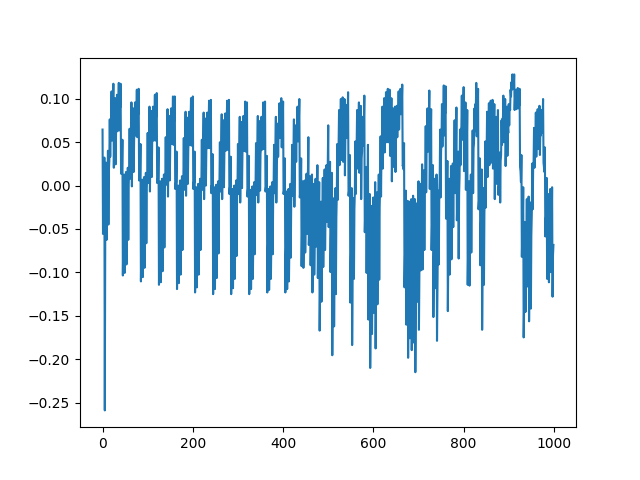

In [15]:
program_target(scope, fw_path)
get_plot_trace()

## Second Set of Results

### XMEGA Results

You should've gotten something that looks like this:
![xmega_power2](https://wiki.newae.com/images/5/5c/Jupyter_B2_xmega_pow2.png)

If you compare it to our original measurement:
![xmega_power1_2](https://wiki.newae.com/images/4/44/Jupyter_B2_XMEGA0.png)

It should be pretty clear that our instructions start 15-20 samples in and end at roughly 180 samples for our new plot (or at ~140 for the original). If we think about what's going on, this makes sense:
* The device consumes less power here since it's not doing I/O or accessing SRAM or flash (besides loading each instruction)
* The length of these sections is also about as long as expected (we're sampling at 4x the clock speed, so 1 cycle is 4 samples): 
    * The original length of our instructions is about 120 samples (40 for 10 `nop` and 80 for 10 `mul`)
    * The new length of our instructions is about 160 samples (80 for 20 `nop` and 80 for 10 `mul`)
    
You might already be able to tell where in this zone each set of instructions are happening, but to be sure, let's add 10 more `nop` instructions after the `mul` instructions.

```C
trigger_high();

//16 hex bytes held in 'pt' were sent
//from the computer. Store your response
//back into 'pt', which will send 16 bytes
//back to computer. Can ignore of course if
//not needed

asm volatile(
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
::
);

asm volatile(
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
::
);

asm volatile(
"mul r0,r1" "\n\t"
"mul r0,r1" "\n\t"
"mul r0,r1" "\n\t"
"mul r0,r1" "\n\t"
"mul r0,r1" "\n\t"
"mul r0,r1" "\n\t"
"mul r0,r1" "\n\t"
"mul r0,r1" "\n\t"          
"mul r0,r1" "\n\t"
"mul r0,r1" "\n\t"
::
);

asm volatile(
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
"nop"       "\n\t"
::
);

trigger_low();
```

### Arm Results

## Final Capture

In [ ]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET"
cd ../../hardware/victims/firmware/simpleserial-base-lab2
make PLATFORM=$1 CRYPTO_TARGET=$2

In [ ]:
program_target(scope, fw_path)
get_plot_trace()

## Final Set of Results

### XMEGA Results

You should now have a trace like this:
![XMEGA3](https://wiki.newae.com/images/5/5a/Jupyter_B2_XMEGA3.png)

As you might expect, our 20 `nop` are happening roughly between samples 15 and 95. Our 10 `mul` are happening between samples 95 and 175 while our final set of `nop` are happening from about 175 to 205 samples. We can see that the `nop` instructions have slightly lower power consumption than the `mul` as well. 

## Disconnecting from ChipWhisperer

Now that we're done with the tutorial, we'll need to disconnect from ChipWhisperer, so that we can connect to it in a different tutorial:

In [18]:
scope.dis()
target.dis()

## Conclusion

In this tutorial you have learned how power analysis can tell you the operations being performed on a microcontroller. In future work we will move towards using this for breaking various forms of security on devices. In particular, Tutorial B3-1 will examine how we can use this information to exploit a password check.